In [1]:
import pandas as pd

In [2]:
filen="/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/K562_02.17.2022_bias_128_4_1234_0.5_fold_0/08_01_2023_motif_scanning/mooods_run/clustered_overlaps_resolved_based_on_cwm_activations_normed.bed"
peak_bed_path="/oak/stanford/groups/akundaje/projects/chrombpnet/model_inputs/ENCODE_ATAC_downloads/K562/idr1.bed.gz"
bwp = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/data/K562_unstranded.bw"
scale = 2.148851624974651
inputs = []
inputs.append([filen,peak_bed_path,bwp, scale])

filen="/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/IMR90/IMR90_04.09.2022_bias_128_4_1234_0.4_fold_0/08_01_2023_motif_scanning/mooods_run/clustered_overlaps_resolved_based_on_cwm_activations_normed.bed"
peak_bed_path="/oak/stanford/groups/akundaje/projects/chrombpnet/model_inputs/ENCODE_ATAC_downloads/IMR90/idr1.bed.gz"
bwp = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/IMR90/data/IMR90_unstranded.bw"
scale = 0.5309343825662685
inputs.append([filen,peak_bed_path,bwp, scale])

filen="/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/HEPG2/HEPG2_05.09.2022_bias_128_4_1234_0.8_fold_0/08_01_2023_motif_scanning/mooods_run/clustered_overlaps_resolved_based_on_cwm_activations_normed.bed"
peak_bed_path="/oak/stanford/groups/akundaje/projects/chrombpnet/model_inputs/ENCODE_ATAC_downloads/HEPG2/idr1.bed.gz"
bwp = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/HEPG2/data/HEPG2_unstranded.bw"
scale=2.3092462701201955
inputs.append([filen,peak_bed_path,bwp, scale])

filen="/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/H1ESC/H1ESC_05.09.2022_bias_128_4_1234_0.8_fold_0/08_01_2023_motif_scanning/mooods_run/clustered_overlaps_resolved_based_on_cwm_activations_normed.bed"
peak_bed_path="/oak/stanford/groups/akundaje/projects/chrombpnet/model_inputs/ATAC/croo/H1ESC/peak/idr_reproducibility/idr.optimal_peak.narrowPeak.gz"
bwp = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/H1ESC/data/H1ESC_unstranded.bw"
scale = 0.4310586420145473
inputs.append([filen,peak_bed_path,bwp, scale])

filen="/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/GM12878_03.01.2022_bias_128_4_1234_0.4_fold_0/08_01_2023_motif_scanning/mooods_run/clustered_overlaps_resolved_based_on_cwm_activations_normed.bed"
peak_bed_path="/oak/stanford/groups/akundaje/projects/chrombpnet/model_inputs/ENCODE_ATAC_downloads/GM12878/idr1.bed.gz"
bwp = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/data/GM12878_unstranded.bw"
scale = 2.6455171206660832
inputs.append([filen,peak_bed_path,bwp, scale])




In [3]:
#data = pd.read_csv(filen,sep="\t",header=None)
#inputs

In [28]:
import os
import subprocess
import numpy as np
import pandas as pd
import tempfile
import pyBigWig

def get_hits_from_dataset(filen,peak_bed_path,bigwig_path, scale, data_id):
    def filter_hits_for_peaks(
        moods_out_bed_path, peak_bed_path, bw, scale, data_id
    ):
        """
        Filters MOODS hits for only those that (fully) overlap a particular set of
        peaks. `peak_bed_path` must be a BED file; only the first 3 columns are
        used. A new column is added to the resulting hits: the index of the peak in
        `peak_bed_path`. If `peak_bed_path` has repeats, the later index is kept.
        """
        # First filter using bedtools intersect, keeping track of matches
        temp_file = "addons/hits_filtered_bed_k562_atac.tmp"
        filtered_hits_path = "addons/hits_filtered_bed_k562_atac.bed"
        comm = ["bedtools", "intersect"]
        comm += ["-wa", "-wb"]
        comm += ["-f", "1"]  # Require the entire hit to overlap with peak
        comm += ["-a", moods_out_bed_path]
        comm += ["-b", peak_bed_path]
        with open(temp_file, "w") as f:
            print(comm)
            proc = subprocess.Popen(comm, stdout=f)
            proc.wait()

        # Create mapping of peaks to indices in `peak_bed_path`
        peak_table = pd.read_csv(
            peak_bed_path, sep="\t", header=None, index_col=False,
            usecols=[0, 1, 2, 8], names=["chrom", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]
        )
        peak_keys = (
            peak_table["chrom"] + ":" + peak_table["start"].astype(str) + "-" + \
            peak_table["end"].astype(str)
        ).values
        peak_index_map = {k : str(i) for i, k in enumerate(peak_keys)}

        # Convert last three columns to peak index
        f = open(temp_file, "r")
        g = open(filtered_hits_path, "w")
        for line in f:
            tokens = line.strip().split("\t")
            #print(tokens)
            g.write("\t".join((tokens[0:4])))
            peak_index = peak_index_map["%s:%s-%s" % tuple(tokens[11:14])]
            peak_index = peak_index + "_" + str(data_id)
            #print(tokens[0],tokens[1],int(tokens[2]))
            #print(tokens[11],tokens[12],int(tokens[13]))

            peak_summit_dist = ((int(tokens[1])+int(tokens[2]))/2) - ((int(tokens[12])+int(tokens[13]))/2)

            peak_signal = np.sum(np.nan_to_num(bw.values(tokens[11],int(tokens[12]),int(tokens[13]))))/scale
            g.write("\t" + peak_index + "\t" + str(np.round(peak_summit_dist,2)) + "\t" + str(peak_signal) + "\n")
        f.close()
        g.close()

    peak_table = pd.read_csv(
        peak_bed_path, sep="\t", header=None, index_col=False
    )

    peak_table[2] = peak_table[1]+peak_table[9]+500
    peak_table[1] = peak_table[1]+peak_table[9]-500

    peak_table.to_csv("addons/summit_centered_peak_k562_atac.bed",sep="\t",header=False, index=False)
    bwin = pyBigWig.open(bigwig_path)
    filter_hits_for_peaks(
        filen, 'addons/summit_centered_peak_k562_atac.bed', bwin, scale, data_id
    )

    data = pd.read_csv("addons/hits_filtered_bed_k562_atac.bed",sep="\t",header=None)
    
    return data

In [29]:
dataframes = []
for idx in range(len(inputs)):
    print(idx)
    data = get_hits_from_dataset(inputs[idx][0],inputs[idx][1],inputs[idx][2],inputs[idx][3],idx)
    dataframes.append(data)

0
['bedtools', 'intersect', '-wa', '-wb', '-f', '1', '-a', '/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/K562_02.17.2022_bias_128_4_1234_0.5_fold_0/08_01_2023_motif_scanning/mooods_run/clustered_overlaps_resolved_based_on_cwm_activations_normed.bed', '-b', 'addons/summit_centered_peak_k562_atac.bed']
1
['bedtools', 'intersect', '-wa', '-wb', '-f', '1', '-a', '/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/IMR90/IMR90_04.09.2022_bias_128_4_1234_0.4_fold_0/08_01_2023_motif_scanning/mooods_run/clustered_overlaps_resolved_based_on_cwm_activations_normed.bed', '-b', 'addons/summit_centered_peak_k562_atac.bed']
2
['bedtools', 'intersect', '-wa', '-wb', '-f', '1', '-a', '/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/HEPG2/HEPG2_05.09.2022_bias_128_4_1234_0.8_fold_0/08_01_2023_motif_scanning/mooods_run/clustered_overlaps_resolved_based_on_cwm_activations_normed.bed', '-b', 'addons/summit_centered_peak_k562_atac.bed']
3
['bedtools', 'intersect', '-

In [30]:
data = pd.concat(dataframes)

In [31]:
data.shape

(2341850, 7)

In [32]:
data["index"] = data[0] + "_" + data[1].astype(str) + "_" + data[2].astype(str) + "_" + data[3].astype(str) 
data.head()

,0,1,2,3,4,5,6,index
0,chr1,69355,69369,0_23_ZN350_HUMAN.H11MO.0.C,66705_0,74.0,426.274197,chr1_69355_69369_0_23_ZN350_HUMAN.H11MO.0.C
1,chr1,69355,69369,0_23_ZN350_HUMAN.H11MO.0.C,92955_0,-361.0,391.837198,chr1_69355_69369_0_23_ZN350_HUMAN.H11MO.0.C
2,chr1,69355,69369,0_23_ZN350_HUMAN.H11MO.0.C,141439_0,284.0,337.389511,chr1_69355_69369_0_23_ZN350_HUMAN.H11MO.0.C
3,chr1,69759,69764,0_0_GATA3_GATA_1,66705_0,473.5,426.274197,chr1_69759_69764_0_0_GATA3_GATA_1
4,chr1,69759,69764,0_0_GATA3_GATA_1,92955_0,38.5,391.837198,chr1_69759_69764_0_0_GATA3_GATA_1


In [33]:
data_n = data.groupby(["index"], group_keys=False).apply(lambda x: x.loc[x[5].abs().idxmin()])

In [34]:
data.shape


(2341850, 8)

In [35]:
data_n.shape

(1285535, 8)

In [36]:
data_n.head()

,0,1,2,3,4,5,6,index
index,,,,,,,,
chr10_100005969_100005976_0_2_TEAD1_MOUSE.H11MO.0.A,chr10,100005969,100005976,0_2_TEAD1_MOUSE.H11MO.0.A,33165_1,-487.5,1373.051028,chr10_100005969_100005976_0_2_TEAD1_MOUSE.H11M...
chr10_100006013_100006019_0_3_FOXI1_MA0042.2,chr10,100006013,100006019,0_3_FOXI1_MA0042.2,33165_1,-444.0,1373.051028,chr10_100006013_100006019_0_3_FOXI1_MA0042.2
chr10_100006092_100006099_0_0_FOS+JUN_MA0099.3,chr10,100006092,100006099,0_0_FOS+JUN_MA0099.3,33165_1,-364.5,1373.051028,chr10_100006092_100006099_0_0_FOS+JUN_MA0099.3
chr10_100006305_100006313_0_0_IRF4_HUMAN.H11MO.0.A,chr10,100006305,100006313,0_0_IRF4_HUMAN.H11MO.0.A,73824_4,-155.0,1003.962507,chr10_100006305_100006313_0_0_IRF4_HUMAN.H11MO...
chr10_100006422_100006434_1_1_FOSL2+JUNB_MA1138.1,chr10,100006422,100006434,1_1_FOSL2+JUNB_MA1138.1,33165_1,-32.0,1373.051028,chr10_100006422_100006434_1_1_FOSL2+JUNB_MA1138.1


183.0


Text(0.5, 1.0, '')

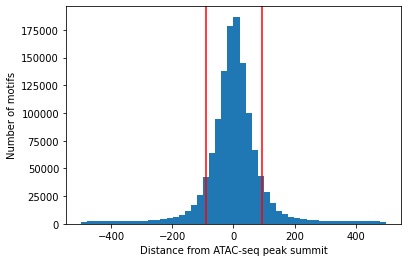

In [37]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

data_n.hist(column=5,bins=50,grid=False)
plt.axvline(x=np.quantile(data_n[5],0.90), color='r', linestyle='-')
plt.axvline(x=np.quantile(data_n[5],0.10), color='r', linestyle='-')
print(np.quantile(data_n[5],0.90)-np.quantile(data_n[5],0.10))

plt.xlabel("Distance from ATAC-seq peak summit")
plt.ylabel("Number of motifs")
plt.title("")

#plt.savefig("subfigs/motif_density_around_summit_k562_atac.pdf", dpi=300, transparent=True)


In [38]:
peak_table_orig = pd.read_csv(
        peak_bed_path, sep="\t", header=None, index_col=False
    )

In [39]:
np.mean((peak_table_orig[2]-peak_table_orig[1]))

954.321409500902

In [40]:
motif_density = data.groupby([4]).size()

In [41]:
accessibility = data.groupby([4])[6].mean()

In [42]:
merged = accessibility.to_frame().join(motif_density.to_frame())


In [43]:
data

,0,1,2,3,4,5,6,index
0,chr1,69355,69369,0_23_ZN350_HUMAN.H11MO.0.C,66705_0,74.0,426.274197,chr1_69355_69369_0_23_ZN350_HUMAN.H11MO.0.C
1,chr1,69355,69369,0_23_ZN350_HUMAN.H11MO.0.C,92955_0,-361.0,391.837198,chr1_69355_69369_0_23_ZN350_HUMAN.H11MO.0.C
2,chr1,69355,69369,0_23_ZN350_HUMAN.H11MO.0.C,141439_0,284.0,337.389511,chr1_69355_69369_0_23_ZN350_HUMAN.H11MO.0.C
3,chr1,69759,69764,0_0_GATA3_GATA_1,66705_0,473.5,426.274197,chr1_69759_69764_0_0_GATA3_GATA_1
4,chr1,69759,69764,0_0_GATA3_GATA_1,92955_0,38.5,391.837198,chr1_69759_69764_0_0_GATA3_GATA_1
...,...,...,...,...,...,...,...,...
603350,chrX,156013491,156013499,0_2_ELF5_HUMAN.H11MO.0.A,90446_4,-256.0,642.596484,chrX_156013491_156013499_0_2_ELF5_HUMAN.H11MO.0.A
603351,chrX,156013511,156013521,0_5_REL_MA0101.1,54781_4,37.0,692.870209,chrX_156013511_156013521_0_5_REL_MA0101.1
603352,chrX,156013511,156013521,0_5_REL_MA0101.1,90446_4,-235.0,642.596484,chrX_156013511_156013521_0_5_REL_MA0101.1
603353,chrX,156016598,156016606,0_2_ELF5_HUMAN.H11MO.0.A,84856_4,-242.0,308.068314,chrX_156016598_156016606_0_2_ELF5_HUMAN.H11MO.0.A


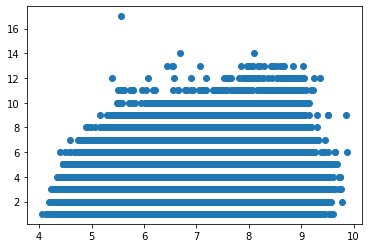

In [44]:
import matplotlib.pyplot as plt
plt.scatter(np.log(merged[6]),merged[0])

271
11662
66181
147941
180647
154852
121130
89562
45562
10141
820
[1.988929889298893, 2.0962956611215917, 2.34163883894169, 2.550753340858856, 2.6669858896079095, 2.7849042957146177, 2.9539750681086434, 3.311102923114714, 3.7755146832887054, 4.106399763336949, 4.014634146341463]


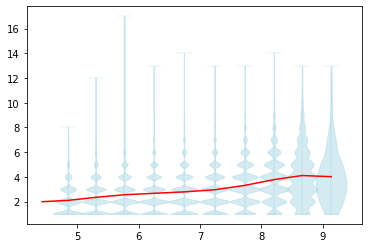

In [45]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

def equal_bin_v2(N, m):
    idx = np.linspace(0,m,N.size, endpoint=0).astype(int)
    return idx[N.argsort().argsort()]  

#bins = np.linspace(0, 12, 10)
#digitized = np.digitize(np.log(pval_signal), bins)
#bin_means = [np.mean(np.array(jaccard_scores)[digitized == i]) for i in range(1, len(bins))]

#idxs = equal_bin_v2(np.log(merged[6]), 10)
bins = np.linspace(4, 11, 15)
idxs = np.digitize(np.log(merged[6]), bins)

bin_vals = [np.mean(np.array(merged[0])[idxs == i]) for i in range(1, max(idxs))]
bin_means = [np.mean(np.array(merged[0])[idxs == i]) for i in range(1, max(idxs))]
bin_vals = [np.array(merged[0])[idxs == i] for i in range(1, max(idxs))]

pval_means = [np.mean(np.log(merged[6])[idxs == i]) for i in range(1, max(idxs))]
bin_std = [np.std(np.array(merged[0])[idxs == i]) for i in range(1, max(idxs))]

#bin_std1 = [np.quantile(np.array(merged[0])[idxs == i],0.11) for i in range(2, max(idxs))]
#bin_std2 = [np.quantile(np.array(merged[0])[idxs == i],0.99) for i in range(2, max(idxs))]

#plt.boxplot(bin_vals,showfliers=False,showmeans=True)
#plt.ylim((0,6))
#plt.errorbar(pval_means, bin_means, yerr=bin_std, fmt='o')
#len(pval_means)

import seaborn as sns
import pandas as pd
#for i in range(len(pval_means)):
#print(bin_vals)
#print(pval_means)
parts = plt.violinplot(bin_vals[1:],positions=pval_means[1:], showmeans=False)
for pc in parts['bodies']:
    pc.set_facecolor('#ADD8E6')
    pc.set_edgecolor('#ADD8E6')
    pc.set_alpha(0.5)
    
#for pc in parts['cmaxes']:
    #pc.set_edgecolor('#ADD8E6')
parts['cmaxes'].set_linewidth(0.1)
parts['cmins'].set_linewidth(0.1)
parts['cbars'].set_linewidth(0.1)

#parts['cmaxes'].set_alpha(0.8)
    
       
#    tips = pd.DataFrame([[pval_means[i]]*len(bin_vals[i]),bin_vals[i]])
#    sns.stripplot(data=tips)
for i in range(len(bin_vals)):
    print(len(bin_vals[i]))
#plt.scatter(np.log(merged[6]),merged[0],alpha=0.1)
plt.plot(pval_means, bin_means, 'r-')
#plt.fill_between(pval_means, bin_std1, bin_std2,alpha=0.2)
#plt.xlabel("Total logcounts signal in peaks")
#plt.ylabel("Total number of motifs")
print(bin_means)
#plt.savefig("subfigs/motif_density_with_accessibility_k562_atac_box_plots.pdf", dpi=300, transparent=True)

plt.show()


In [159]:

data = pd.read_csv("addons/hits_filtered_bed_k562_atac.clustered.bed",sep="\t",header=None)

data.head()

,0,1,2,3,4,5,6,7
0,chr1,41372,41377,0_0_GATA3_GATA_1,24261,-227.5,322.0,1
1,chr1,41372,41377,0_0_GATA3_GATA_1,24082,283.5,425.0,1
2,chr1,42187,42192,0_0_GATA3_GATA_1,24322,-90.5,326.0,2
3,chr1,42279,42289,0_3_BACH2_HUMAN.H11MO.0.A,24322,4.0,326.0,3
4,chr1,42334,42339,0_0_GATA3_GATA_1,24322,56.5,326.0,4


In [189]:
peaks_signal = []
motifs_in_peaks_distance = []
peaks_ids = []
for i,r in data.iterrows():
    if r[4] in peaks_ids:
        continue
    peaks_ids.append(r[4])
    peaks_signal.append(r[6])
    motifs_distances = list(set(data[data[4]==r[4]][5]))
    sorted_dist = np.sort(motifs_distances)
    values = []
    
    if len(sorted_dist) == 1:
        right_clust = data[data[7]==r[7]-1]
        left_clust = data[data[7]==r[7]+1]

        motifs_in_peaks_distance.append(values)
        continue
        #if len(right_clust[0].values) > 0:
        #    if right_clust[0].values[0] == r[0]:
        #        values.append(np.abs(((right_clust[1].values[0]+right_clust[2].values[0])/2)-((r[1]+r[2])/2)))
        #if len(left_clust[0].values) > 0:
        #    if left_clust[0].values[0] == r[0]:
        #        values.append(np.abs(((left_clust[1].values[0]+left_clust[2].values[0])/2)-((r[1]+r[2])/2)))
                #print(values[-1])
    
    for jd in range(1,len(sorted_dist)):
        values.append(sorted_dist[jd] - sorted_dist[jd-1])
        if (sorted_dist[jd] - sorted_dist[jd-1]) <0:
            print(sorted_dist)
        #print(values[-1])
    motifs_in_peaks_distance.append(np.mean(values))
        
        

/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obj

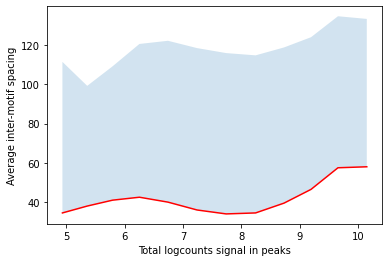

In [190]:
import matplotlib
import matplotlib.pyplot as plt
from itertools import chain

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

def equal_bin_v2(N, m):
    idx = np.linspace(0,m,N.size, endpoint=0).astype(int)
    return idx[N.argsort().argsort()]  

#bins = np.linspace(0, 12, 10)
#digitized = np.digitize(np.log(pval_signal), bins)
#bin_means = [np.mean(np.array(jaccard_scores)[digitized == i]) for i in range(1, len(bins))]

#idxs = equal_bin_v2(np.log(merged[6]), 10)
bins = np.linspace(4, 11, 15)
idxs = np.digitize(np.log(peaks_signal), bins)

bin_vals = [np.mean(list(chain.from_iterable(np.array(motifs_in_peaks_distance)[idxs == i].tolist()))) for i in range(2, max(idxs))]
bin_means = [np.median(list(chain.from_iterable(np.array(motifs_in_peaks_distance)[idxs == i].tolist()))) for i in range(2, max(idxs))]

pval_means = [np.mean(np.log(peaks_signal)[idxs == i]) for i in range(2, max(idxs))]
bin_std = [np.std(list(chain.from_iterable(np.array(motifs_in_peaks_distance)[idxs == i].tolist()))) for i in range(2, max(idxs))]


#bin_std1 = [np.quantile(np.array(merged[0])[idxs == i],0.25) for i in range(2, max(idxs))]
#bin_std2 = [np.quantile(np.array(merged[0])[idxs == i],0.75) for i in range(2, max(idxs))]

#plt.boxplot(bin_vals,showfliers=False,showmeans=True)
#plt.ylim((0,6))
#plt.errorbar(pval_means, bin_means, yerr=bin_std, fmt='o')
#len(pval_means)

plt.plot(pval_means, bin_means, 'r-')
plt.fill_between(pval_means, bin_means, bin_means+(np.array(bin_std)/2),alpha=0.2)
plt.xlabel("Total logcounts signal in peaks")
plt.ylabel("Average inter-motif spacing")

#plt.savefig("subfigs/motif_density_with_accessibility_k562_atac.pdf", dpi=300, transparent=True)

plt.show()


In [ ]:
data

In [170]:
motifs_in_peaks_distance[5]

[1774.0, 9570.0]

In [235]:
#output = list(chain.from_iterable(np.array(motifs_in_peaks_distance)))
output = list([np.median(x) for x in np.array(motifs_in_peaks_distance)])

/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/users/anusri/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/anusri/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


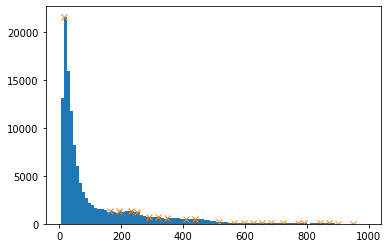

In [249]:
plt.hist(output,bins=100)
plt.plot(bin_edges[peaks],hist[peaks],"x")

In [246]:
output=np.array(output)
output = output[~np.isnan(output)]

hist, bin_edges = np.histogram(output, 100)


In [247]:
import scipy.signal
peaks, _ = scipy.signal.find_peaks(hist)


In [248]:
bin_edges[peaks]

array([ 14.84, 162.44, 191.96, 231.32, 251.  , 290.36, 319.88, 349.4 ,
       408.44, 437.96, 516.68, 565.88, 595.4 , 624.92, 654.44, 683.96,
       723.32, 772.52, 792.2 , 841.4 , 870.92, 900.44, 949.64])